Purpose of this document is to refresh my ML capabilities.

Goal: Predict the next few hours’ prices from past prices and a few exogenous features (wind, load, temperature), evaluate performance, and inspect results.

## Generate artificial data

In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [395]:
# Create temperature, wind and (energy) load.
def temperature(hours, noise_strength_percent=0.1):
    """Assume daily cycle, sinusodial"""
    if isinstance(hours, int):
        hours = np.arange(0, hours)
    
    temperature_change_amplitude = 6 # Unit: DegC - Half the difference in highest and lowest temp.
    average_temperature = 20
    frequency = 2*np.pi / 24  # Unit: 1/h - One day takes 24 hours
    hours_shift = -6  # Unit: h - Make sure that hour = 0 is midnight i.e. coldest
    temperature_noise_factor = 1 + np.random.uniform(-noise_strength_percent, noise_strength_percent, size=len(hours))
    noisy_amplitude = temperature_noise_factor * temperature_change_amplitude
    return noisy_amplitude * np.sin(frequency * hours + hours_shift) + average_temperature


def wind(hours, noise_strength_percent, wind_amplitude=15, shift=5):
    """Cyclic (i.e. oscillations with non-constant frequency)"""
    # Wind is stronger during the day and weaker during the night. 
    # For each day, choose a random sunrise and sundown, and from those, the frequency the oscillation
    
    if isinstance(hours, int):
        hours = np.arange(hours)
    
    average_wind_strength = 15  # Unit: m/s - a gentle wind
    
    def _wind_strength(freq, duration):
        duration = np.arange(0, duration)
        wind_noise_factor = 1 + np.random.uniform(-noise_strength_percent, noise_strength_percent, size=len(duration))
        noisy_amplitude = np.abs(wind_noise_factor * wind_amplitude)
        return noisy_amplitude * np.sin(freq * duration + shift) + average_wind_strength
    
    wind_strength = np.empty_like(hours[:-1])
    hours_counted = 0
    remaining_hours = hours[-1]
    while remaining_hours > 0:
        # Calculate the frequency
        sunrise = np.random.uniform(5, 7)
        sundown = np.random.uniform(17, 19)        
        frequency_day = 2 * np.pi / (2 * (sundown - sunrise))  # Unit: 1 / hour
        duration = np.minimum(remaining_hours, 24)  # If less than one day only do that many hours
        # Find wind strength
        wind_str = _wind_strength(frequency_day, duration)
        # Append values
        upper_append = np.minimum(24, remaining_hours)
        wind_strength[hours_counted : hours_counted + upper_append] = wind_str
        # One less day to calculate
        remaining_hours -= 24  
        hours_counted += 24
   
    return wind_strength


def price(temp, wind, load, noise_strength_percent):
    average_pice = 250  # € / MWh
    noisy_average = average_pice * (1 + np.random.uniform(-noise_strength_percent, noise_strength_percent, size=len(temp)))
    load_to_price = 1 / 20
    wind_to_price = 3
    temp_to_price = 4
    return noisy_average + load_to_price * load - wind_to_price * wind - temp_to_price * temp 

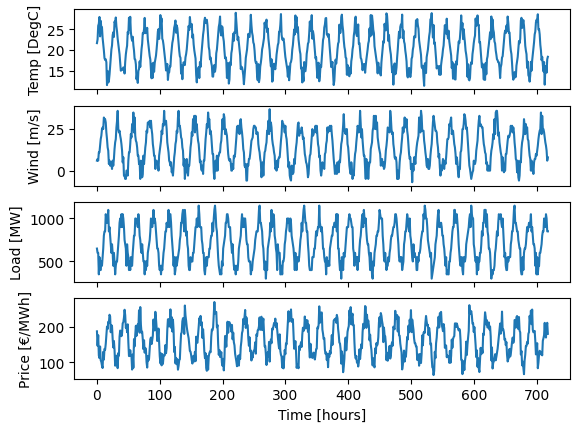

In [410]:
hours = np.arange(24 * 30)
temp_noise = temperature(hours, noise_strength_percent=0.5)[:-1]  # Exclude last point to match size of other
wind_str_noise = wind(hours, noise_strength_percent=0.5)
# Also use the wind algo to estimate energy load
wind_to_megawatt = 50
load = wind_to_megawatt * wind(hours, noise_strength_percent=0.5, wind_amplitude=6, shift=-3)
price_per_hour = price(temp_noise, wind_str_noise, load, noise_strength_percent=0.1)

fig, (ax, ax1, ax2, ax3) = plt.subplots(nrows=4, sharex=True)
hours_plot = hours[:-1]
ax.plot(hours_plot, temp_noise)
ax1.plot(hours_plot, wind_str_noise)
ax2.plot(hours_plot, load)
ax3.plot(hours_plot, price_per_hour)

ax.set(ylabel="Temp [DegC]")
ax1.set(ylabel="Wind [m/s]")
ax2.set(ylabel="Load [MW]")
ax3.set(xlabel="Time [hours]", ylabel="Price [€/MWh]")

plt.show()
plt.close()

In [411]:
# Create dataframe with the data
df = pd.DataFrame({"Temperature": temp_noise, "Wind": wind_str_noise, "Load": load, "Price": price_per_hour, "Hour": hours_plot})
df.set_index("Hour", inplace=True)

## Define Baselines

In [412]:
df["naive_baseline"] = df["Price"].shift(1, fill_value=df["Price"][0])
df["naive_day_baseline"] = df["Price"].shift(24, fill_value=df["Price"][0])
df["naive_weighted"] = 0.5 * df["naive_baseline"] + 0.5 * df["naive_day_baseline"]

# Compute Mean Absolute Error and Root Mean Square Error
def MAE_RMSD(baseline_key: str):
    MAE = np.sum(np.abs(df[baseline_key] - df["Price"])) / len(df)
    RMSD = np.sqrt(np.sum((df[baseline_key] - df["Price"]) ** 2) / len(df))
    return MAE, RMSD

MAE_naive, RMSD_naive = MAE_RMSD("naive_baseline")
MAE_naive_day, RMSD_naive_day = MAE_RMSD("naive_day_baseline")
MAE_naive_weight, RMSD_naive_weight = MAE_RMSD("naive_weighted")

print("Naive")
print(f"MAE = {MAE_naive}")
print(f"RMSD = {RMSD_naive}\n")

print("Naive day")
print(f"MAE = {MAE_naive_day}")
print(f"RMSD = {RMSD_naive_day}\n")

print("Naive weighted")
print(f"MAE = {MAE_naive_weight}")
print(f"RMSD = {RMSD_naive_weight}\n")

Naive
MAE = 22.195875680284697
RMSD = 27.10691747466845

Naive day
MAE = 22.23378823826571
RMSD = 27.90345185488949

Naive weighted
MAE = 18.762909140062323
RMSD = 23.148536452435618



## Feature engineering
- Add lags over different hours
- Add rolling mean and rolling stds over different hours


In [413]:
df["price_lag24"] = df["Price"].shift(12)
df["mean_price_lag6"] = df["Price"].rolling(6).sum()
df["mean_price_lag12"] = df["Price"].rolling(12).sum()
df["std_price_lag6"] = df["Price"].rolling(2).std()
df["std_price_lag12"] = df["Price"].rolling(6).std()
df.head(13)

,Temperature,Wind,Load,Price,naive_baseline,naive_day_baseline,naive_weighted,price_lag24,mean_price_lag6,mean_price_lag12,std_price_lag6,std_price_lag12
Hour,,,,,,,,,,,,
0,21.651705,6,650,187.853277,187.853277,187.853277,187.853277,NaN,NaN,NaN,NaN,NaN
1,22.562296,7,600,146.934381,187.853277,187.853277,187.853277,NaN,NaN,NaN,28.934029,NaN
2,25.848472,6,600,176.904265,146.934381,187.853277,167.393829,NaN,NaN,NaN,21.191908,NaN
3,26.351905,11,350,119.658696,176.904265,187.853277,182.378771,NaN,NaN,NaN,40.478730,NaN
4,27.979268,11,550,112.016250,119.658696,187.853277,153.755986,NaN,NaN,NaN,5.404025,NaN
5,23.277813,15,400,144.876617,112.016250,187.853277,149.934764,NaN,888.243486,NaN,23.235788,30.108740
6,27.033191,19,400,106.088599,144.876617,187.853277,166.364947,NaN,806.478808,NaN,27.427270,26.808041
7,25.336087,21,500,100.987655,106.088599,187.853277,146.970938,NaN,760.532081,NaN,3.606912,28.989606
8,25.500002,25,450,90.804910,100.987655,187.853277,144.420466,NaN,674.432726,NaN,7.200288,18.676133


In [443]:
# Handle NaNs by backfilling
df.bfill()

,Temperature,Wind,Load,Price,naive_baseline,naive_day_baseline,naive_weighted,price_lag24,mean_price_lag6,mean_price_lag12,std_price_lag6,std_price_lag12
Hour,,,,,,,,,,,,
0,21.651705,6,650,187.853277,187.853277,187.853277,187.853277,187.853277,888.243486,1507.322268,28.934029,30.108740
1,22.562296,7,600,146.934381,187.853277,187.853277,187.853277,187.853277,888.243486,1507.322268,28.934029,30.108740
2,25.848472,6,600,176.904265,146.934381,187.853277,167.393829,187.853277,888.243486,1507.322268,21.191908,30.108740
3,26.351905,11,350,119.658696,176.904265,187.853277,182.378771,187.853277,888.243486,1507.322268,40.478730,30.108740
4,27.979268,11,550,112.016250,119.658696,187.853277,153.755986,187.853277,888.243486,1507.322268,5.404025,30.108740
...,...,...,...,...,...,...,...,...,...,...,...,...
714,15.470429,17,900,175.200357,211.952674,212.290606,212.121640,83.311182,1014.026464,1749.361293,25.987813,29.746710
715,16.112359,15,1050,170.198732,175.200357,246.582414,210.891385,99.147532,1064.318755,1820.412493,3.536683,17.852715
716,14.519399,12,1000,199.044500,170.198732,208.106404,189.152568,122.200727,1102.138191,1897.256265,20.397038,17.681019


# Train models

In [444]:
# Test and train data
# Train on the first 50%, test on the remaining 50%
train_test_split = int(len(df) * 0.5)
df_train = df[:train_test_split]
df_test = df[train_test_split:]

column_names = df.columns.values.tolist()
X_names = column_names[:]
X_names.remove("Price")
y_names = ["Price"]

X_train = df_train[X_names]
y_train = df_train[y_names]
X_test = df_test[X_names]
y_test = df_test[y_names]

In [470]:
# Use Ridge and GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor

# Ridge
clf = Ridge(alpha=1.)
ridge = clf.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
y_score = ridge.score(X_test, y_test)

# GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, np.ravel(y_train))
y_pred_reg = reg.predict(X_test)
y_score_reg = reg.score(X_test, y_test)

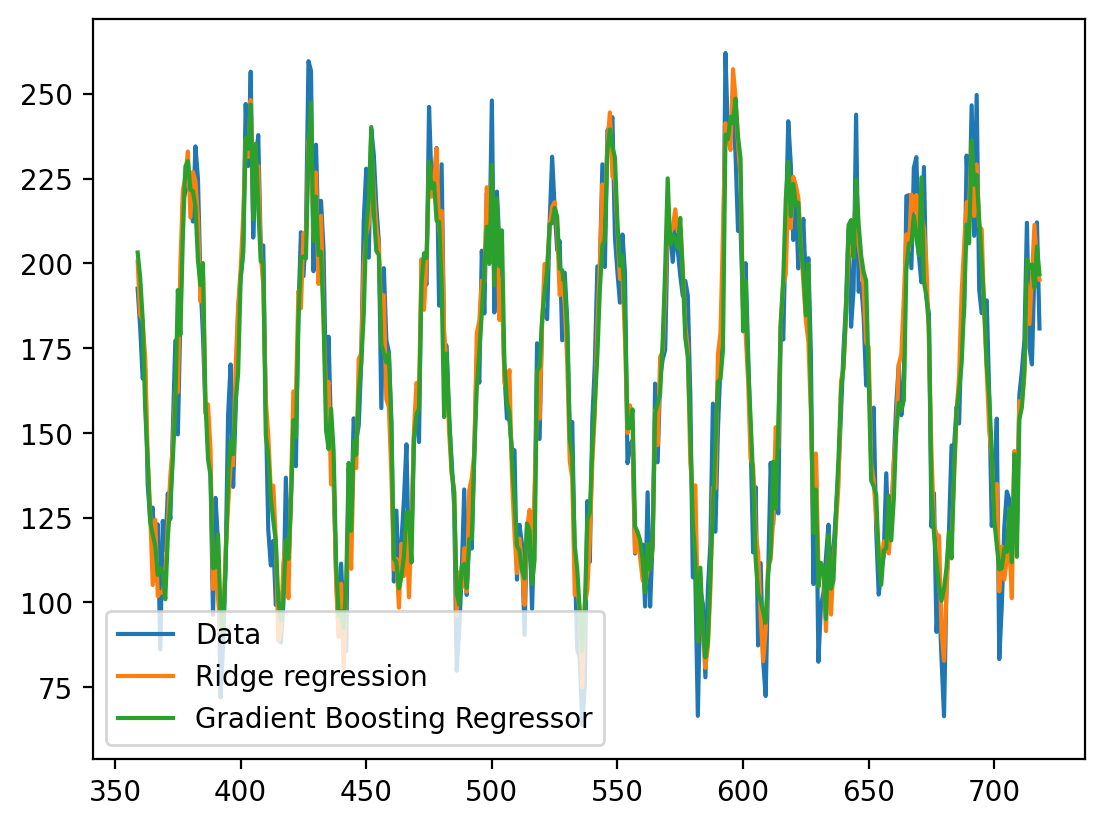

Scores
Ridge: 0.9124437740768638
Gradient: 0.9100473403226361


In [472]:
# Plot comparison
fig, ax = plt.subplots(dpi=200)
ax.plot(y_test, label="Data")
ax.plot(df_test.index, y_pred, label="Ridge regression")
ax.plot(df_test.index, y_pred_reg, label="Gradient Boosting Regressor")
ax.legend()
plt.show()

print("Scores")
print(f"Ridge: {y_score}")
print(f"Gradient: {y_score_reg}")

# Look at deviations/errors

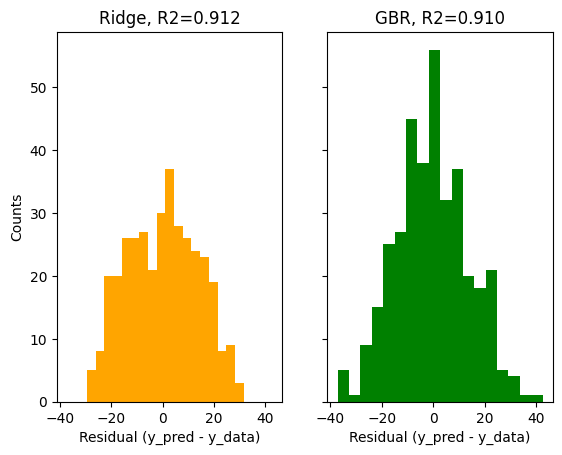

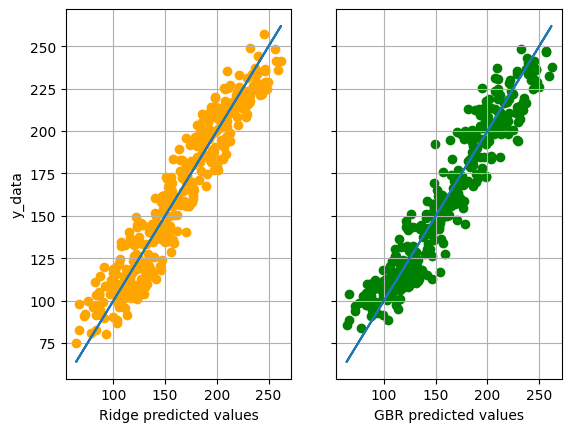

In [ ]:
# The distribution of residuals
residual_ridge = y_pred - np.ravel(y_test)
residual_GBR = y_pred_reg - np.ravel(y_test)

Nbins = int(np.sqrt(np.size(residual_GBR)))  # Is the same for the two residual arrays

fig, (ax, ax_GBR) = plt.subplots(ncols=2, sharey=True, sharex=True)
ax.hist(residual_ridge, bins=Nbins, color="orange")
ax_GBR.hist(residual_GBR, bins=Nbins, color="green")

ax.set(xlabel="Residual (y_pred - y_data)", ylabel="Counts", title=f"Ridge, R2={y_score:.3f}")
ax_GBR.set(xlabel="Residual (y_pred - y_data)", title=f"GBR, R2={y_score_reg:.3f}")
plt.show()
plt.close()

# Plot scatterplot of y_pred vs y_test
fig, (ax, ax_GBR) = plt.subplots(ncols=2, sharey=True, sharex=True)
ax.scatter(y_test, y_pred, color="orange")
ax_GBR.scatter(y_test, y_pred_reg, color="green")
ax.plot(y_test, y_test, "-")
ax_GBR.plot(y_test, y_test, "-")
ax.set(xlabel="Ridge predicted values", ylabel="y_data")
ax_GBR.set(xlabel="GBR predicted values")
ax.grid()
ax_GBR.grid()
plt.show()

We see that the GBR has has more extreme event, but also many more near $0$ compared to the Ridge regressor. In other words, using the GBR, most of the time you will get better predictions, but rare really off events exist. The coefficiant of determination, $R^2$, is so close to being the same they practically are. 